# **Apd-callibration** &rarr;

Apd callibration using dye DY-781-01

**Author: Jean Matias \
Dye Sample: s017 \
Acquired on: 2021/04/30 \
Analysed on: 2021/05/04 \
Last Update: 2022/03/10**


In [39]:
%matplotlib notebook
# %matplotlib widget
import sys
from scipy.optimize import curve_fit
sys.path.append('../scripts/')
from lab import Sample, Analysis, BeamProfile
from calibration import *

In [3]:
help(Analysis)

Help on class Analysis in module lab:

class Analysis(builtins.object)
 |  Analysis(dataPath='../data/raw-data/')
 |  
 |  Creates and handle different Samples.
 |  Ex.:
 |  >>> exp = Analysis()
 |  >>> exp.loaddata(
 |      sampleType='dye',
 |      dataIds=['20201111-101010'],
 |      diluterId='20201111-101110',
 |      emptyId='20201111-101200'
 |  )
 |  
 |  **Analysis protocol**:
 |      In order to get the quantum yield values for a ucnp sample, 
 |      the steps bellow should be followed for a reference dye data
 |      and subsequently for ucnps data. 
 |  
 |      1. Get steady data - it averages data points after the equipmment and samples stabilised. 
 |      2. Calibrate the power meter output (pm) - Volts to mW using standard curves for that.
 |          This is the transmitted power through the cuvette.
 |      3. Calibrate the DAQ output (trigger) - Volts to mW using empty measuremnts.
 |          This is the laser power, i.e. the power before reaching the cuvette.
 | 

In [4]:
help(Sample)

Help on class Sample in module lab:

class Sample(builtins.object)
 |  Sample(path, expId, sampleType)
 |  
 |  Creates an object to handle its data and all the information 
 |  related to its experiment.
 |  
 |  To initialise a sample object use the example:
 |  ```
 |  >>> ucnp = Sample('path/to/data', expId='20210101-101010', sampleType='ucnp')
 |  ```
 |  Sample type can be: ucnp, dye, empty, or diluter. It will define the rules of calculation
 |  for certain methods.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, path, expId, sampleType)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  absorbance(self, diluterAbsorbance=None, filterQuery='laser_power > 0', recalculate=False)
 |      Calculates absorbance of the emitter compound present on the aqueous medium.
 |      
 |      Args: 
 |          diluterAbsorbance (float): Diluter absorbance used as a reference to calculate the emitter's absorbance
 |          recalculate (bool): If True it wil

# Beam Profile analysis

In [2]:
bp1 = BeamProfile('s1_20210430_785nm_100mA_ND1_ET015.png')

In [3]:
bp1.trim(1.5)
bp1.removebackground(5)


In [4]:
pwd

'C:\\Users\\jean.matias\\Documents\\develop\\system-paper-analysis\\notebooks'

<IPython.core.display.Javascript object>


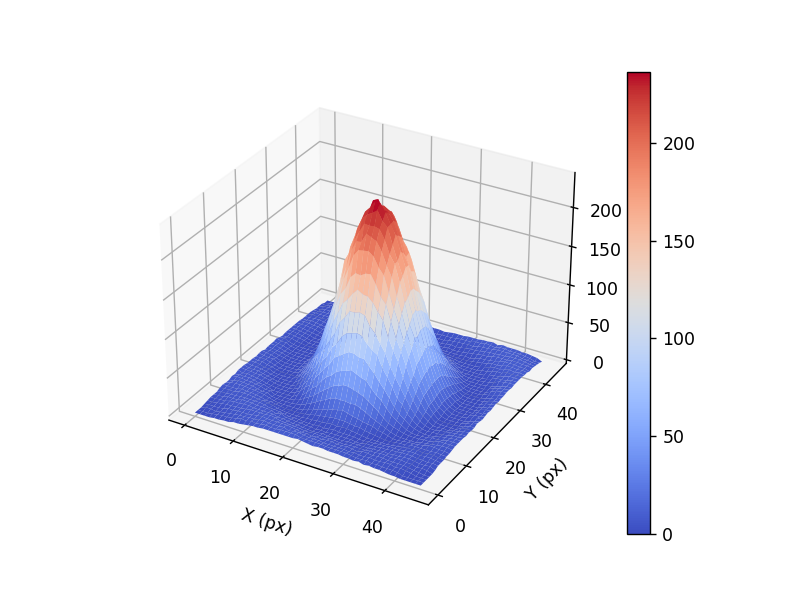

In [5]:
bp1.plotsurf()

In [6]:
bp1.beamwidth()

0.008215

### Dye data

In [7]:
dCalib = Analysis()

In [8]:
dCalib.loaddata('dye', dataIds='20210430-123435', diluterId='20210430-123054', emptyId='20210430-122357') # s1 min


In [9]:
dCalib.get('setbeamprofile', dict(beamprofileObj=bp1), which=[0, 1, 2])


20210430-122357: empty - Success!
20210430-123054: diluter - Success!
20210430-123435: dye - Success!


In [10]:
dCalib.get('apdpower', dict(recalculate=True))

ok
20210430-123435: dye - Calibrate the pm channel before proceding.
20210430-123435: dye - Calibrate the trigger channel before proceding.
20210430-123435: dye - Calibrate the pm channel before proceding.
20210430-123435: dye - Calibrate the trigger channel before proceding.
20210430-123435: dye - Calibrate the trigger channel before proceding.
20210430-123435: dye - Success!


In [11]:
dCalib.details()

,exp_id,type,sample,apd_gain,comments,density_filter,laser_wavelength,power_meter_range,range_start,range_end,range_step_size,samples_per_ch,sampling_rate,time_per_step
0,20210430-122357,empty,empty,min,-,0,785nm,91mW,0.0,1.678,0.01,1000.0,3333.333333,0.3
1,20210430-123054,diluter,ethanol,min,-,0,785nm,91mW,0.0,1.678,0.01,1000.0,3333.333333,0.3
2,20210430-123435,dye,s017,min,-,0,785nm,91mW,0.0,1.678,0.01,1000.0,3333.333333,0.3


<IPython.core.display.Javascript object>


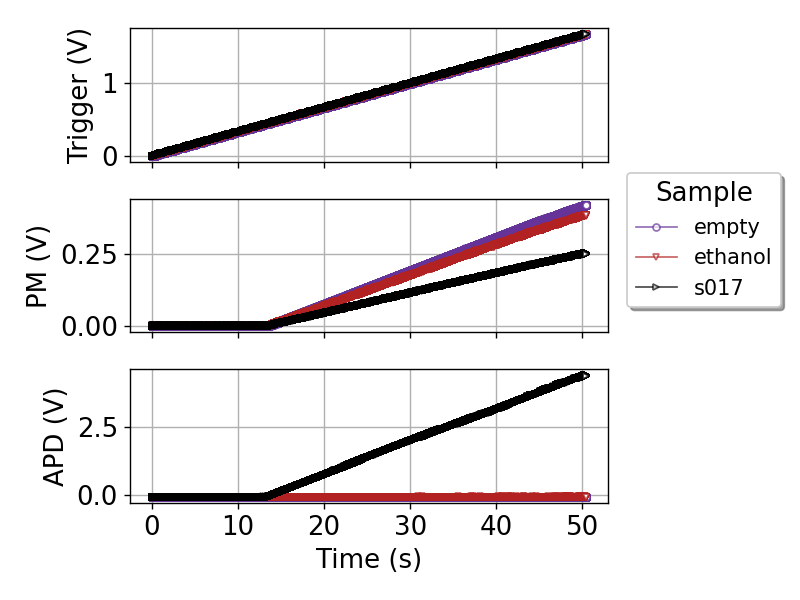

In [12]:
fig, axs = dCalib.view(includeDiluter=True, includeEmpty=True, label='sample')

### Get Steady data

In [13]:
dCalib.get('steadydata', dict(fromPt=400, toPt=1000, recalculate=False, precision=2), includeDiluter=True, includeEmpty=True)

20210430-122357: empty - Success!
20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


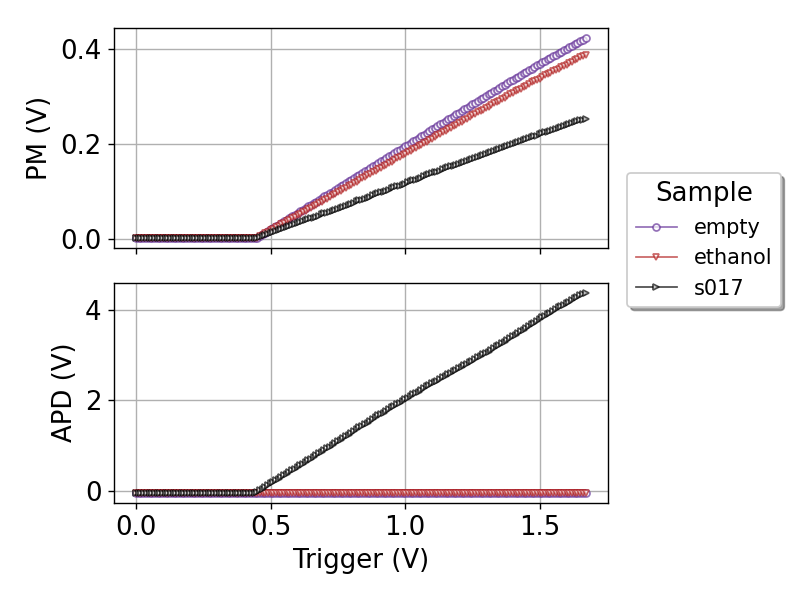

In [14]:
fig, axs = dCalib.view(x='trigger', yList=['pm', 'apd'], includeDiluter=True, includeEmpty=True, label='sample')

In [15]:
dCalib.get('removebackground', dict(channel='apd', baseline='trigger < 0.15'), includeEmpty=True, includeDiluter=True)

20210430-122357: empty - Success!
20210430-123054: diluter - Success!
20210430-123435: dye - Success!


In [16]:
dCalib.get('removebackground', dict(channel='pm', baseline='trigger < 0.15'), includeEmpty=True, includeDiluter=True)

20210430-122357: empty - Success!
20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


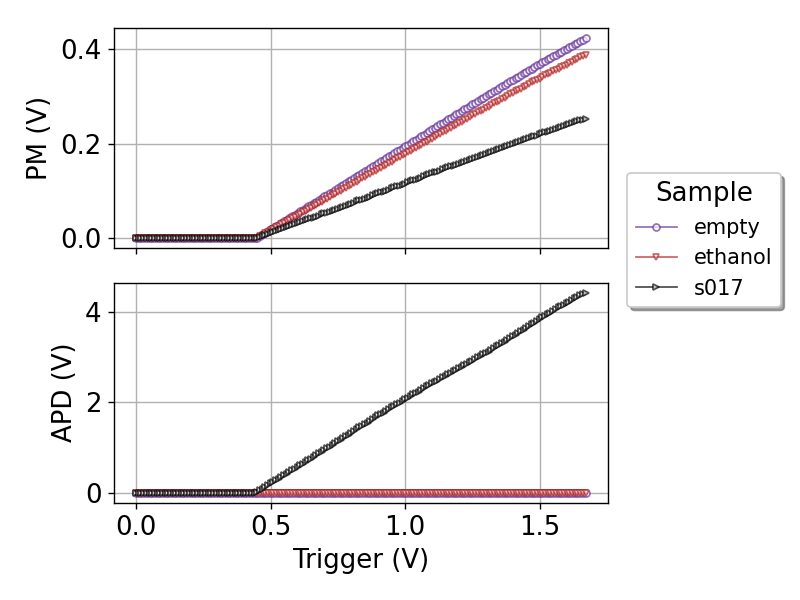

In [17]:
fig, axs = dCalib.view(x='trigger', yList=['pm', 'apd'], includeDiluter=True, includeEmpty=True, label='sample')

### Power meter calibration

<IPython.core.display.Javascript object>


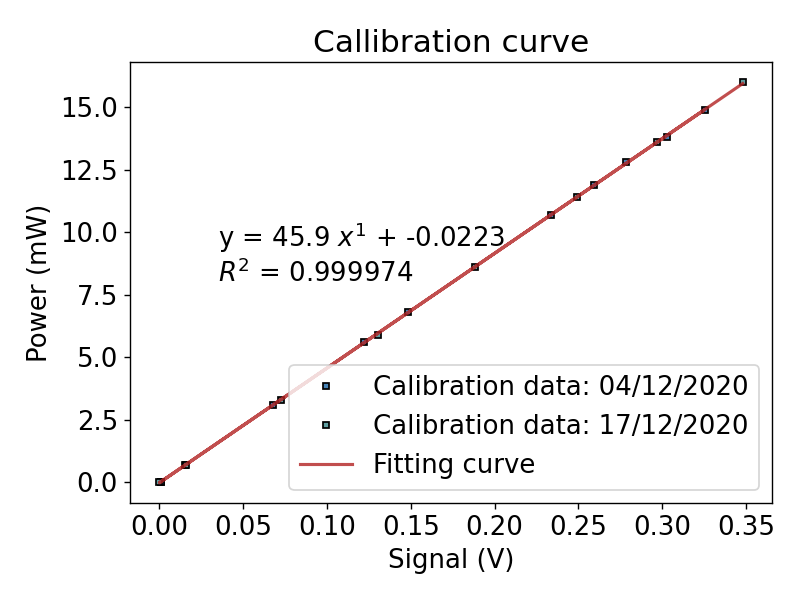

In [18]:
coeffs, r_val = calibratePM(laser=785, pmRange=91, degree=1)
calibfunc = np.poly1d(coeffs)
def calibfunc0(x): return(calibfunc(x))

In [19]:
dCalib.get('calibrate', dict(calibFunction=calibfunc0, channel='pm', recalculate=True), which=[0, 1, 2])

20210430-122357: empty - Success!
20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


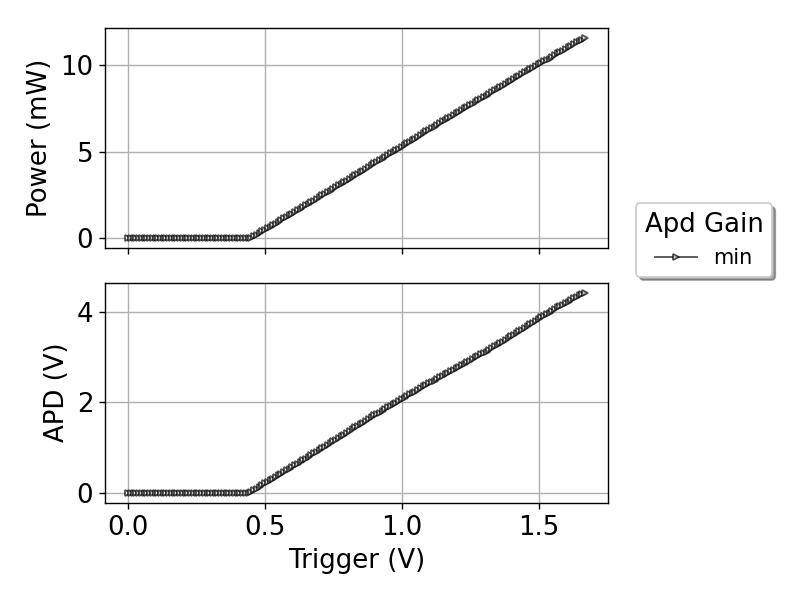

In [20]:
fig, axs = dCalib.view(x='trigger', yList=['transmitted_power', 'apd'], label='apd_gain')

### Trigger calibration

<IPython.core.display.Javascript object>


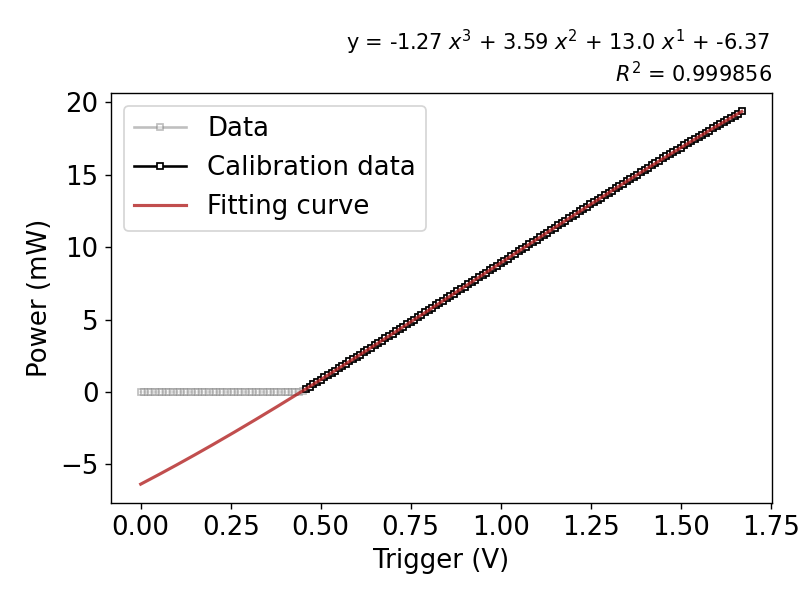

In [21]:
coeffs, r_val = dCalib.sample(0).polyfit(x='trigger', y='transmitted_power', degree=3, condition='x > 0.45', show=True)
calibfunc = np.poly1d(coeffs)
def calibfunc2(x): return(calibfunc(x))

In [22]:
dCalib.get('calibrate', dict(calibFunction=calibfunc2, channel='trigger', recalculate=True), which=[0, 1, 2])

20210430-122357: empty - Success!
20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


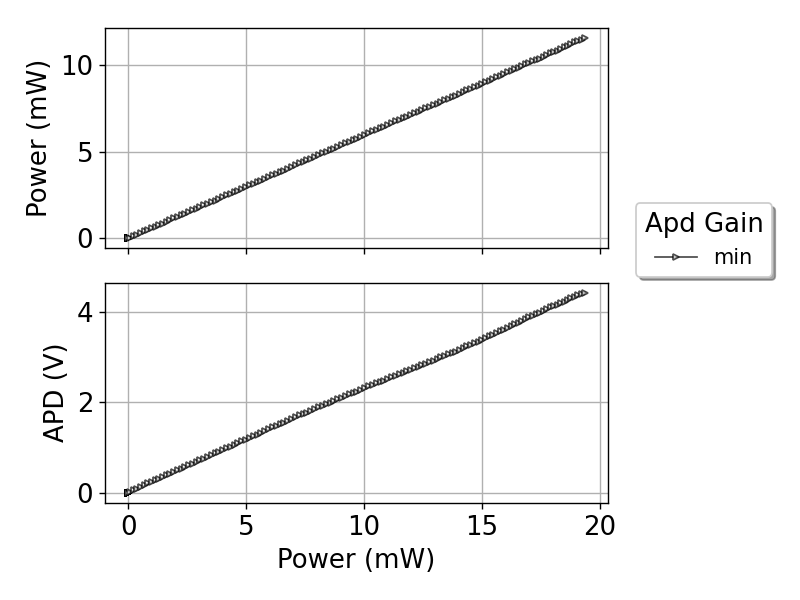

In [23]:
fig, axs = dCalib.view(x='laser_power', yList=['transmitted_power', 'apd'], label='apd_gain')

In [24]:
dCalib.get('powdensatcentre', dict(recalculate=True), includeDiluter=True, includeEmpty=True)

20210430-122357: empty - Success!
20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


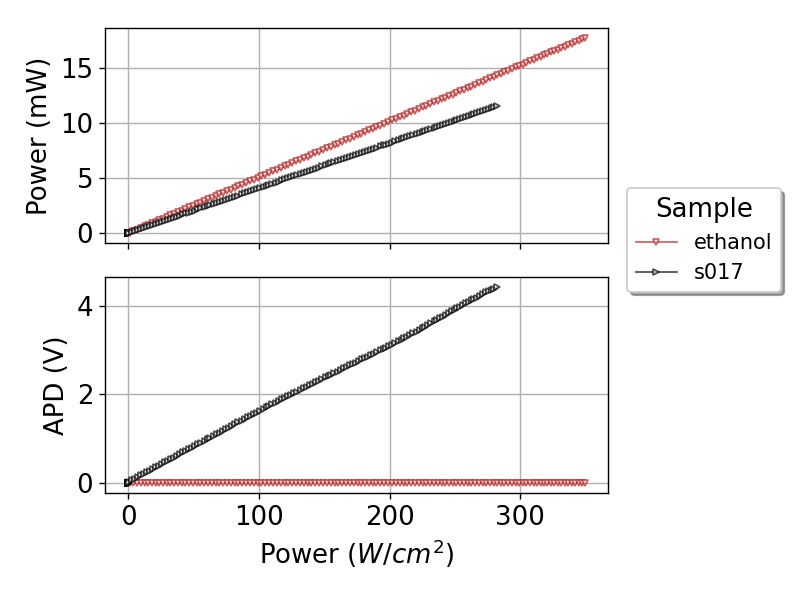

In [25]:
fig, axs = dCalib.view(x='pow_dens_at_centre', yList=['transmitted_power', 'apd'], label='sample', includeDiluter=True, includeEmpty=False)

## Absorbance

In [26]:
dCalib.get('sampleabsorbance', dict(recalculate=True), includeDiluter=True)

20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


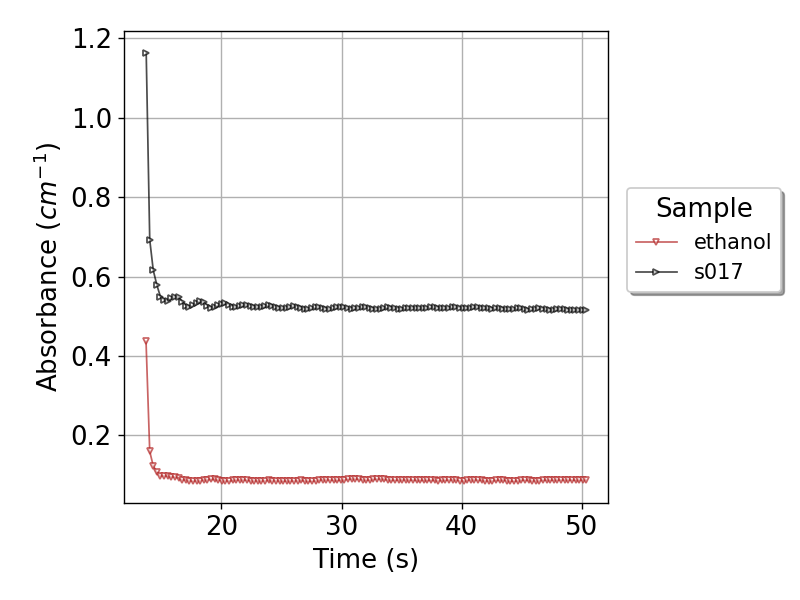

In [27]:
fig, axs = dCalib.view(x='time_daq', yList=['sample_absorbance'], label='sample', includeDiluter=True)

In [28]:
_, abMean1, abStd1, _ = dCalib.sample(1).sampleabsorbance(filterQuery='time_daq > 17', recalculate=True)
print(f'{dCalib.sample(1)._sampleType}: {abMean1=}, {abStd1=}')

diluter: abMean1=0.08684507487388451, abStd1=0.0013022208133697101


In [29]:
dCalib.get('absorbance', dict(recalculate=True), includeDiluter=True)

20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


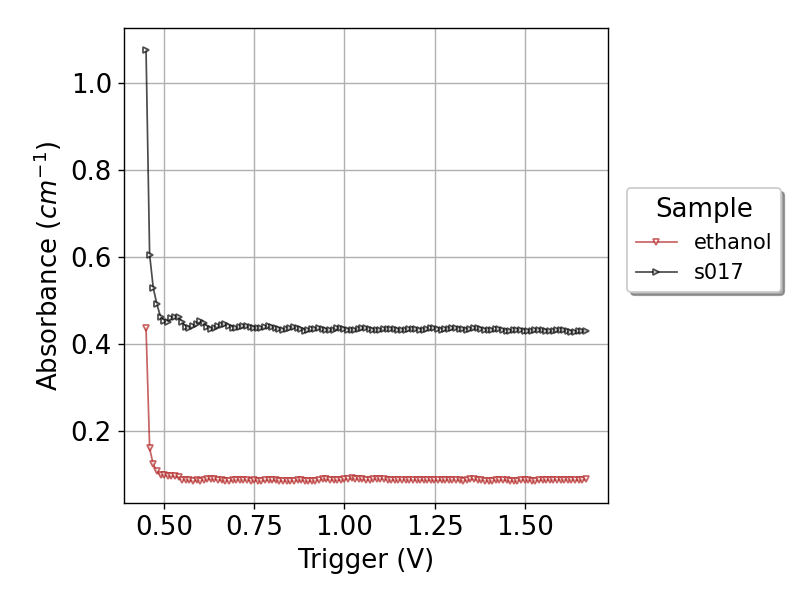

In [30]:
fig, axs = dCalib.view(x='trigger', yList=['absorbance'], label='sample', includeDiluter=True)

In [31]:
dCalib.get('absorbedpower', dict(region=[0.45, 0.55], useMean=True, filterQuery='time_daq > 17', recalculate=True), includeDiluter=True)

20210430-123054: diluter - Success!
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


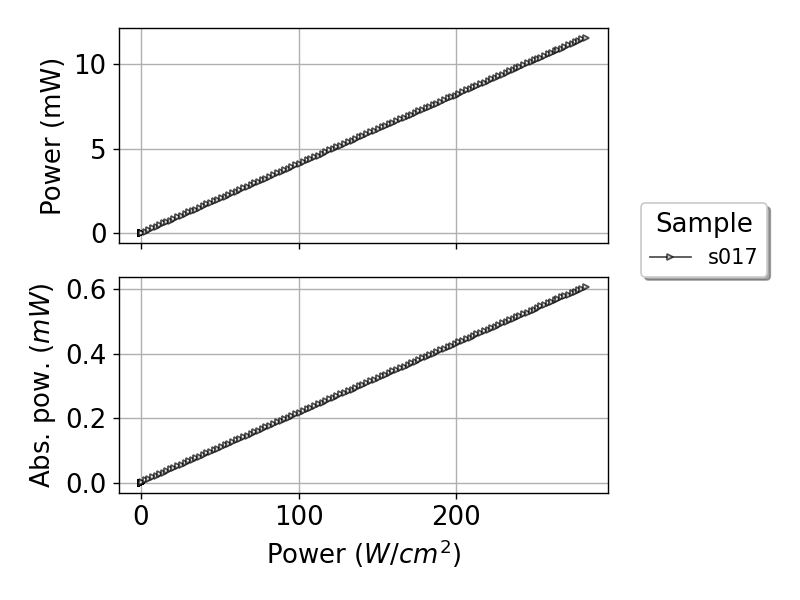

In [32]:
fig, axs = dCalib.view(x='pow_dens_at_centre', yList=['transmitted_power', 'absorbed_power'], label='sample', includeDiluter=False)

In [31]:
dCalib.sample(2)._sampleDetails

Sample                             s017
SoluteProductCode             dy-781-01
SoluteComposition                   Dye
SoluteConcentration_mgml           high
SoluteVolume_uL                   500.0
SoluteProvider                  Dyomics
Solvent                         ethanol
SolventConcentration               pure
SolventVolume_uL                   1500
SolventProvider             sofia/ardee
Cuvette                          quartz
ExcitationWavelength_nm           785.0
EmissionWavelength_nm             800.0
DateOfPrep                   25/11/2020
FinalConcentration_mgml             NaN
refractiveIndex                     NaN
QuantumYield                      0.124
comments                            NaN
Name: 18, dtype: object

In [33]:
dCalib.get('apdpower', dict(recalculate=True))

ok
20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


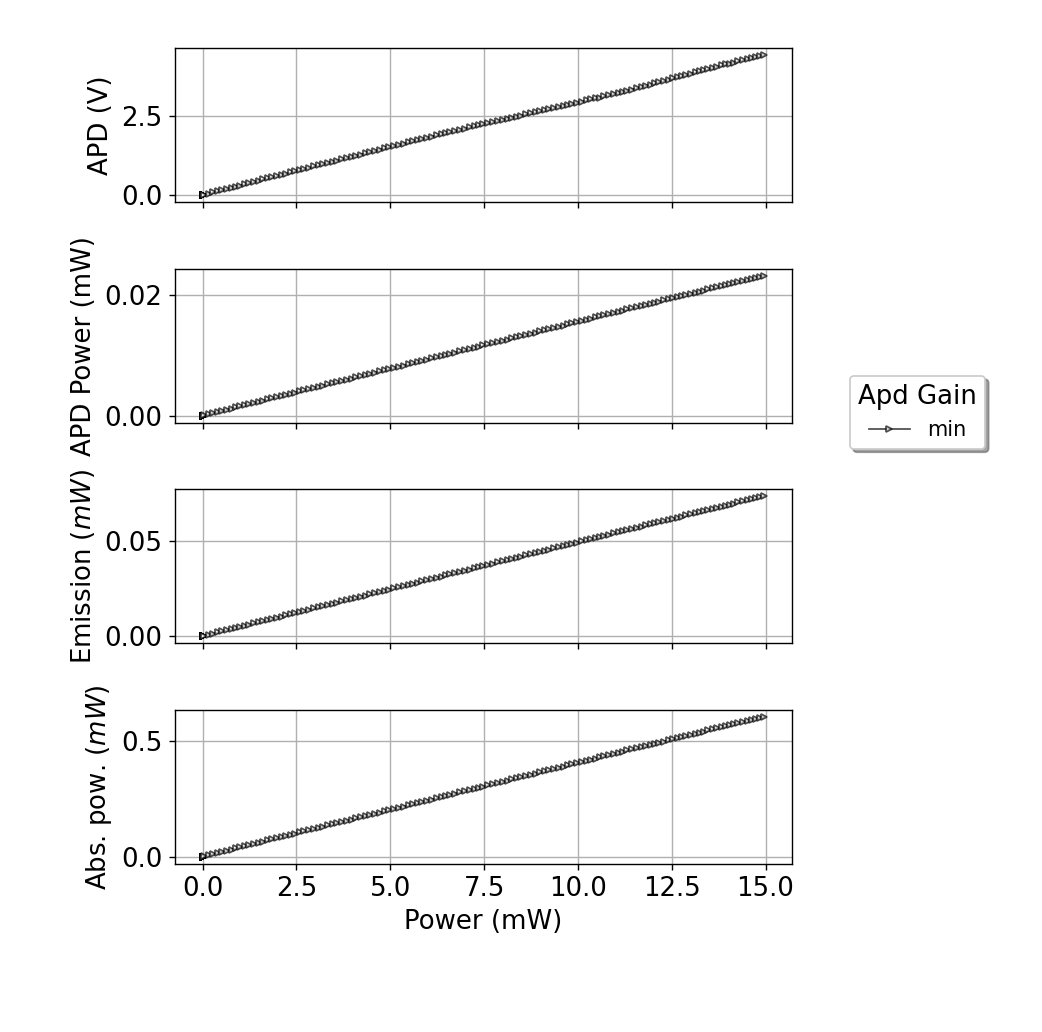

In [34]:
fig, axs = dCalib.view(x='power_at_centre', yList=['apd', 'apd_power', 'emitted_power', 'absorbed_power'], label='apd_gain')

## Get kappa $\kappa$

In [35]:
dCalib.get('kappa', dict(period=20, recalculate=True))

20210430-123435: dye - Success!


<IPython.core.display.Javascript object>


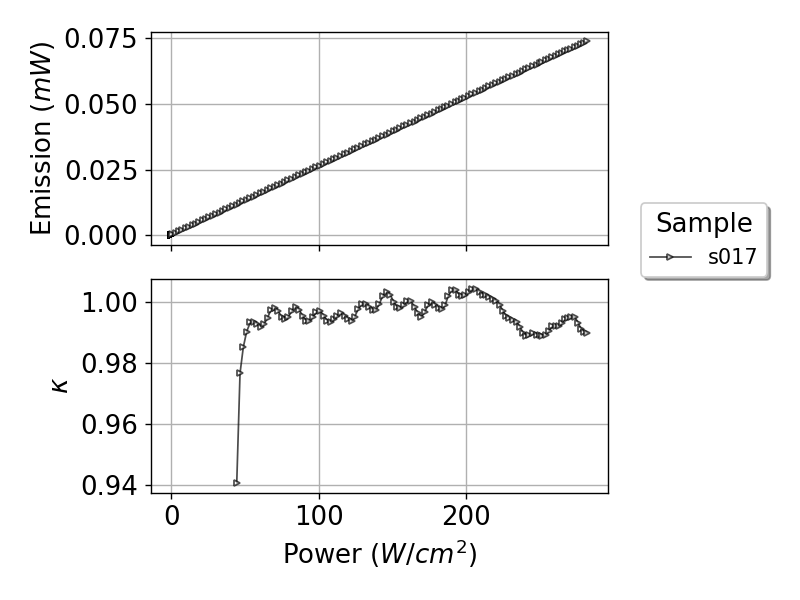

In [36]:
fig, axs = dCalib.view(x='pow_dens_at_centre', yList=['emitted_power', 'kappa'], label='sample')

In [26]:
axs[1].set_ylim([0.9, 1.1])

(0.9, 1.1)

### APD fitting

In [40]:
popt, pcov = curve_fit(lambda x, a: a * x, dCalib.sample(2).data()['apd'], dCalib.sample(2).data()['apd_power'])
popt

array([0.00525246])

<IPython.core.display.Javascript object>


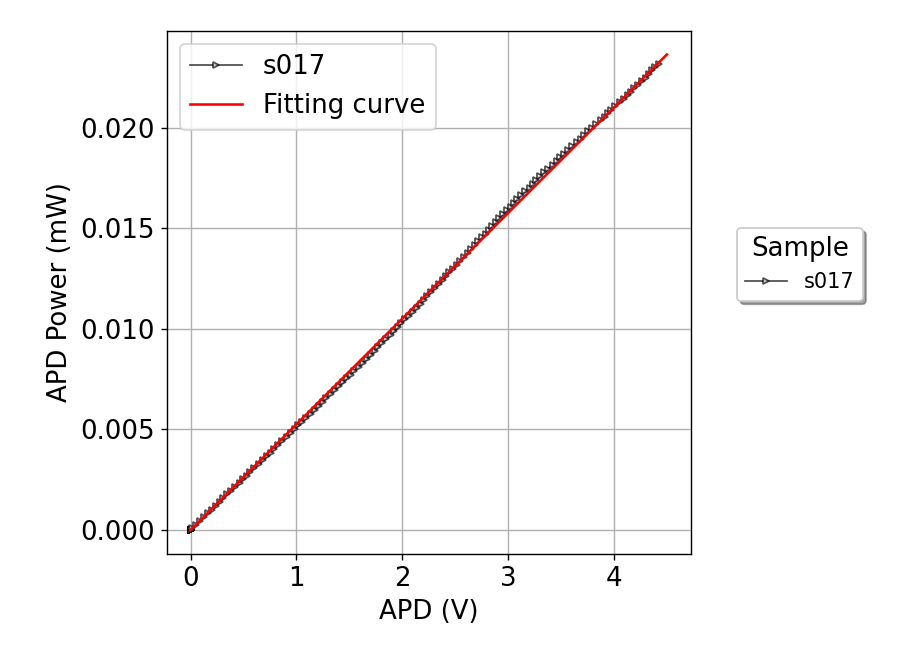

In [47]:
fig, axs = dCalib.view(x='apd', yList=['apd_power'], label='sample')
axs[0].plot([0, 4.5], [0, popt[0]*4.5], 'r', label='Fitting curve')
pl.legend()